# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with Unity's Reacher environment. Single agent

### 1. Import the Necessary Packages

In [1]:
# !pip -q install ./python

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from tensorboardX import SummaryWriter
from unityagents import UnityEnvironment
from udacity.ddpg_agent2 import Agent

In [2]:
def get_env():
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="./Reacher_Linux_Multi/Reacher.x86_64", no_graphics = True)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="Reacher_Multi.app", no_graphics = False)
    return env


def welcome():
    env = get_env()

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)

    # size of each action
    action_size = brain.vector_action_space_size

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('Number of agents:', num_agents)
    print('Size of each action:', action_size)
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

    return env, state_size, action_size

In [3]:
import sys
import time

def ddpg(env, agent, n_episodes=2000, max_t=int(10000), prefix=''):
    scores_deque = deque(maxlen=100)
    scores = []
    episode_horizons = deque(maxlen=100)
    max_score = -np.Inf
    brain_name = env.brain_names[0]
    solved = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        n_agents = state.shape[0]
        agent.reset()
        score = np.zeros((n_agents, 1), dtype=np.float32)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)[..., None]
            done = np.array(env_info.local_done)[..., None]
            if t+1 == max_t:
                done = np.ones_like(done, dtype = np.bool)

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.all(done):
                episode_horizons.append(t)
                break
        
        scores_deque.append(score)
        scores.append(score)
        writer.add_scalar('score_G', np.mean(scores), i_episode)
        
        _mu_score_moving = np.mean(np.mean(scores_deque, axis = 1))
        print('\rEpisode {}\t100-episode avg score: {:.2f}\tScore: {:.2f}\tTime Step: {}'.format(i_episode, _mu_score_moving, float(np.mean(score)), agent.total_steps), end="")

        if i_episode % 50 == 0:
            print('\rEpisode {}\t100-episode avg score: {:.2f}\tAvg. Horizon: {:.2f}'.format(i_episode, _mu_score_moving, np.mean(episode_horizons)))


        if (np.mean(scores_deque) >= 30.) and (i_episode > 99) and (not solved):
            print('\nThe environment was solved in {} episodes'.format(i_episode))
            solved = True

    torch.save(agent.actor_local.state_dict(), './models/{}checkpoint_actor_multi.pth'.format(prefix))
    torch.save(agent.critic_local.state_dict(), './models/{}checkpoint_critic_multi.pth'.format(prefix))
    return scores

### 2. Instantiate the Environment

In [4]:
env, state_size, action_size = welcome()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [5]:
max_t = 1000
n_episodes = 1000

### 3.1 Naiive Exploration (Parameter Space Noise Exploration)

In [7]:
writer = SummaryWriter(log_dir='./logs/naiive_param_space_exploration_multi/horizon_{}'.format(max_t))
agent = Agent(state_size=state_size, 
              action_size=action_size, 
              random_seed = 10, 
              writer=writer, 
              explore_assumptions=False)
scores = ddpg(env, agent, n_episodes=n_episodes, max_t = max_t, prefix='naiive_param_space_exploration_')

Episode 50	100-episode avg score: 5.10	Avg. Horizon: 999.00ep: 50000
Episode 100	100-episode avg score: 19.56	Avg. Horizon: 999.00ep: 100000
Episode 131	100-episode avg score: 30.19	Score: 37.19	Time Step: 131000
The environment was solved in 131 episodes
Episode 150	100-episode avg score: 34.79	Avg. Horizon: 999.00ep: 150000
Episode 200	100-episode avg score: 36.01	Avg. Horizon: 999.00ep: 200000
Episode 250	100-episode avg score: 36.55	Avg. Horizon: 999.00ep: 250000
Episode 300	100-episode avg score: 36.19	Avg. Horizon: 999.00ep: 300000
Episode 350	100-episode avg score: 35.93	Avg. Horizon: 999.00ep: 350000
Episode 400	100-episode avg score: 36.17	Avg. Horizon: 999.00ep: 400000
Episode 450	100-episode avg score: 35.93	Avg. Horizon: 999.00ep: 450000
Episode 500	100-episode avg score: 35.62	Avg. Horizon: 999.00ep: 500000
Episode 550	100-episode avg score: 35.31	Avg. Horizon: 999.00ep: 550000
Episode 600	100-episode avg score: 35.19	Avg. Horizon: 999.00ep: 600000
Episode 650	100-episode 

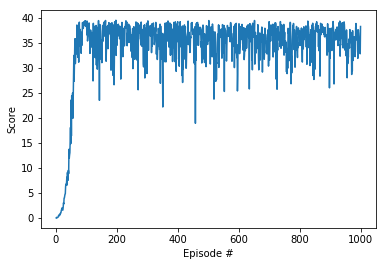

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), [np.mean(s) for s in scores])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()